<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_04_01_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 15.8 MB/s eta 0:00:00


In [2]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 248 (delta 6), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (248/248), 7.20 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (117/117), done.


## 2.2 Setup of Data Collection Functions

In [3]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [4]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1428 non-null   datetime64[ns]
 1   open       1428 non-null   float64       
 2   high       1428 non-null   float64       
 3   low        1428 non-null   float64       
 4   close      1428 non-null   float64       
 5   adj_close  1428 non-null   float64       
 6   volume     1428 non-null   int64         
 7   ticker     1428 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.4+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [5]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [6]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

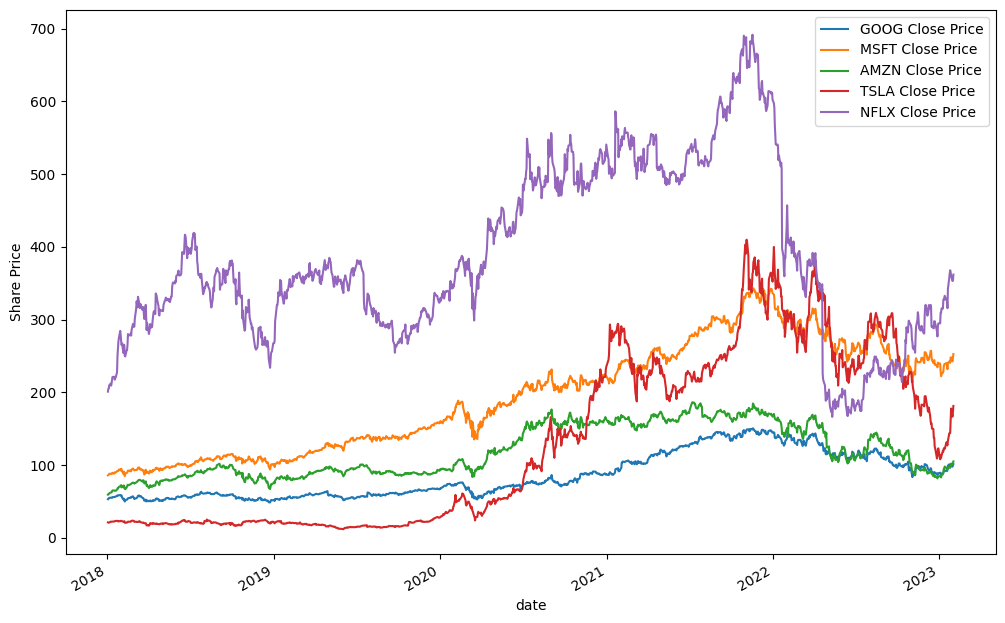

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/indexes/base.py", line 3629, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'headline'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e9dd5037dc9d>", line 15, in <cell line: 14>
    frame['average headlines'] = frame['headline'].rolling(20).mean()

TypeError: ignored

In [8]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [7]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [8]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 32s]
val_loss: 0.010549369268119335

Best val_loss So Far: 0.0011754091829061508
Total elapsed time: 00h 37m 21s
36/36 [==============================] - 1s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014    
[0.0013631473993882537, 0.0013631473993882537]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 20, 'dropout2': 0.7, 'neurons_hidden2': 50, 'dropout3': 0.1, 'neurons_hidden3': 50}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [9]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


In [10]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape


4/4 [==============================] - 0s 6ms/step


(127, 1)

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [11]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [12]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 4ms/step


(1270, 1)

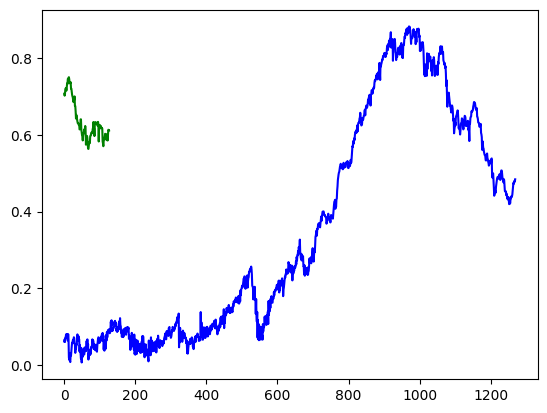

In [13]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()


##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [14]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [15]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/t0er457k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ofdn2dte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17439', 'data', 'file=/tmp/tmpdf26z35w/t0er457k.json', 'init=/tmp/tmpdf26z35w/ofdn2dte.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelpbyp65ql/prophet_model-20230401142054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/u_cr36cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4ki__0_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91151', 'data', 'file=/tmp/tmpdf26z35w/u_cr36cm.json', 'init=/tmp/tmpdf26z35w/4ki__0_b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelx01l9v46/prophet_model-20230401142055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rkpn4c96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v37svaky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/yozwcx39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87784', 'data', 'file=/tmp/tmpdf26z35w/e365d3w0.json', 'init=/tmp/tmpdf26z35w/yozwcx39.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model8vlgf9om/prophet_model-20230401142225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9y48er1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e27mvjv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9479', 'data', 'file=/tmp/tmpdf26z35w/9y48er1e.json', 'init=/tmp/tmpdf26z35w/e27mvjv4.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelw5lhzvk5/prophet_model-20230401142226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e1c2509s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/hcl0o72l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/aiuf6z8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ruv6etbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48813', 'data', 'file=/tmp/tmpdf26z35w/aiuf6z8a.json', 'init=/tmp/tmpdf26z35w/ruv6etbo.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model1ryh46n5/prophet_model-20230401142321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ewytette.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kpa9wxlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/7wxd1qsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ynjjkggp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43920', 'data', 'file=/tmp/tmpdf26z35w/7wxd1qsk.json', 'init=/tmp/tmpdf26z35w/ynjjkggp.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelrwat_lut/prophet_model-20230401142419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1v31vume.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kctmx3w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/21zwdilm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zgd0w4h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26082', 'data', 'file=/tmp/tmpdf26z35w/21zwdilm.json', 'init=/tmp/tmpdf26z35w/zgd0w4h5.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelwyzdojew/prophet_model-20230401142521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/88ia88u5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z2luslt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:26:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/j2t0ddn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g8fascsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28609', 'data', 'file=/tmp/tmpdf26z35w/j2t0ddn2.json', 'init=/tmp/tmpdf26z35w/g8fascsw.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeld4vrf36v/prophet_model-20230401142625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/o8vrigr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/680pu3qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


14:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/wovu70s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z4gybhzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16370', 'data', 'file=/tmp/tmpdf26z35w/wovu70s2.json', 'init=/tmp/tmpdf26z35w/z4gybhzq.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model4rr_6ugs/prophet_model-20230401142752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ipwrjq7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kw86xr5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/22i_8bz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zyy2nxug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18818', 'data', 'file=/tmp/tmpdf26z35w/22i_8bz6.json', 'init=/tmp/tmpdf26z35w/zyy2nxug.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelzwfo2qe4/prophet_model-20230401142950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/toz6dm4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rl0nue96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/8aptnk2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67195', 'data', 'file=/tmp/tmpdf26z35w/rsoa3sb9.json', 'init=/tmp/tmpdf26z35w/8aptnk2r.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelg24kcl8w/prophet_model-20230401143150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/x4xo43a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9p4e9_ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53107', 'data', 'file=/tmp/tmpdf26z35w/x4xo43a1.json', 'init=/tmp/tmpdf26z35w/9p4e9_ba.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeljd4t3gr9/prophet_model-20230401143152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/cc5zocv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ay7ykt_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/33im4ws2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2541', 'data', 'file=/tmp/tmpdf26z35w/x6qch2tr.json', 'init=/tmp/tmpdf26z35w/33im4ws2.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelof4p1tfq/prophet_model-20230401143352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/h5q27j0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/60t5hjiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27166', 'data', 'file=/tmp/tmpdf26z35w/h5q27j0_.json', 'init=/tmp/tmpdf26z35w/60t5hjiu.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model7vwhhrkv/prophet_model-20230401143354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vj6a8kah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2ona776r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/w0sj6g9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3j7curi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7596', 'data', 'file=/tmp/tmpdf26z35w/w0sj6g9d.json', 'init=/tmp/tmpdf26z35w/3j7curi3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model3bbe90u0/prophet_model-20230401143601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/_87zyy95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/q0rth34t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/r965n7go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1dg5o2oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98923', 'data', 'file=/tmp/tmpdf26z35w/r965n7go.json', 'init=/tmp/tmpdf26z35w/1dg5o2oj.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelst8chku3/prophet_model-20230401143820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vf1mn_qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4y32of6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zv59p558.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9797', 'data', 'file=/tmp/tmpdf26z35w/qvque2l5.json', 'init=/tmp/tmpdf26z35w/zv59p558.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv2zfai6h/prophet_model-20230401144157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fzw6k6w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2_r45tf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58045', 'data', 'file=/tmp/tmpdf26z35w/fzw6k6w6.json', 'init=/tmp/tmpdf26z35w/2_r45tf3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv9mj14zl/prophet_model-20230401144159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/s34d1dqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/iq5tl41a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/afue2qmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g5hibljd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97626', 'data', 'file=/tmp/tmpdf26z35w/afue2qmr.json', 'init=/tmp/tmpdf26z35w/g5hibljd.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelf5v6v8pi/prophet_model-20230401144444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fsbhnucr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zulw_erw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/lm2sa070.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38639', 'data', 'file=/tmp/tmpdf26z35w/oudc45eb.json', 'init=/tmp/tmpdf26z35w/lm2sa070.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelczcd96ir/prophet_model-20230401144725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/i_gk_p1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/nnktmrw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90222', 'data', 'file=/tmp/tmpdf26z35w/i_gk_p1t.json', 'init=/tmp/tmpdf26z35w/nnktmrw6.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeltym4fu2i/prophet_model-20230401144726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/tx9tr22g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3byugpf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v75lrfek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/eyvln51d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35408', 'data', 'file=/tmp/tmpdf26z35w/v75lrfek.json', 'init=/tmp/tmpdf26z35w/eyvln51d.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelkqqgm8yb/prophet_model-20230401145005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/mend8r8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g_sa8qm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2q17ept3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5gjbn81g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38258', 'data', 'file=/tmp/tmpdf26z35w/2q17ept3.json', 'init=/tmp/tmpdf26z35w/5gjbn81g.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model5ykjzp3_/prophet_model-20230401145243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5hjy33hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2xjxaw4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3i5e662e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/71__gz9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56782', 'data', 'file=/tmp/tmpdf26z35w/3i5e662e.json', 'init=/tmp/tmpdf26z35w/71__gz9b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model_aysgm9q/prophet_model-20230401145535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/soj4jwhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ffuh4rka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Minimum cross-validation error: 185.1688513042688


### 4.3.1 Forecasting with Prophet

In [17]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [18]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/o_h6o1ub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/a8r_1dfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99880', 'data', 'file=/tmp/tmp07i3fj8b/o_h6o1ub.json', 'init=/tmp/tmp07i3fj8b/a8r_1dfy.json', 'output', 'file=/tmp/tmp07i3fj8b/prophet_modellzn76es8/prophet_model-20230407183357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/vwgvoc11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/bp58x6bj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83390', 'data', 'file=/tmp/tmp07i3fj8b/vwgvoc11.json', 'init=/tmp/tmp07i3fj8b/bp58x6bj.json', 'output', 'file=/tmp/tmp07i3fj8b/prophet_model_3ufkzdb/prophet_model-20230407183400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/1pmqjxuj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/e518t4pd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [19]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/brrzo9db.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/v01qu24_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48229', 'data', 'file=/tmp/tmp07i3fj8b/brrzo9db.json', 'init=/tmp/tmp07i3fj8b/v01qu24_.json', 'output', 'file=/tmp/tmp07i3fj8b/prophet_model_jp0_hhl/prophet_model-20230407184007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/3ymuxwtm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/iuyett6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97894', 'data', 'file=/tmp/tmp07i3fj8b/3ymuxwtm.json', 'init=/tmp/tmp07i3fj8b/iuyett6s.json', 'output', 'file=/tmp/tmp07i3fj8b/prophet_model2f1_sh5a/prophet_model-20230407184009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/oufu00zo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp07i3fj8b/ic4f5v26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [20]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [21]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [22]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'MSFT_PROPHET':np.array(msft_train_data),  'LSTM':LSTM_MSFT_yhat.flatten()}
msft_hybrid_df = pd.DataFrame(msft_hybrid)
#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()

reshaped_msft = msft_hybrid_df['MSFT_PROPHET'].to_numpy()
reshaped_msft= reshaped_msft.reshape(-1,1)

scaled_msft = scaler2.fit_transform(reshaped_msft)
msft_hybrid_df['MSFT_Pscaled'] = scaled_msft.flatten()
msft_hybrid_df=msft_hybrid_df.drop('MSFT_PROPHET', axis=1)

#verifying the transform
print("msft hybrid",msft_hybrid_df.shape)
#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))
print(y_train2.shape)

36/36 [==============================] - 0s 6ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
msft hybrid (1143, 2)
y_hybrid (1143, 1)
(1133, 1)


In [23]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 11ms/step - loss: 0.2228 - mae: 0.3502
Epoch 2/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0723 - mae: 0.2167
Epoch 3/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0418 - mae: 0.1635
Epoch 4/300
48/48 [==============================] - 1s 14ms/step - loss: 0.0243 - mae: 0.1244
Epoch 5/300
48/48 [==============================] - 1s 15ms/step - loss: 0.0178 - mae: 0.1069
Epoch 6/300
48/48 [==============================] - 1s 15ms/step - loss: 0.0141 - mae: 0.0936
Epoch 7/300
48/48 [==============================] - 1s 15ms/step - loss: 0.0123 - mae: 0.0859
Epoch 8/300
48/48 [==============================] - 1s 15ms/step - loss: 0.0111 - mae: 0.0823
Epoch 9/300
48/48 [==============================] - 1s 16ms/step - loss: 0.0095 - mae: 0.0754
Epoch 10/300
48/48 [==============================] - 1s 15ms/step - loss: 0.0095 - mae: 0.0760
Epoch 11/300
48/48 [==============================] - 1s 13ms

###4.4.2 LOSS and MAE

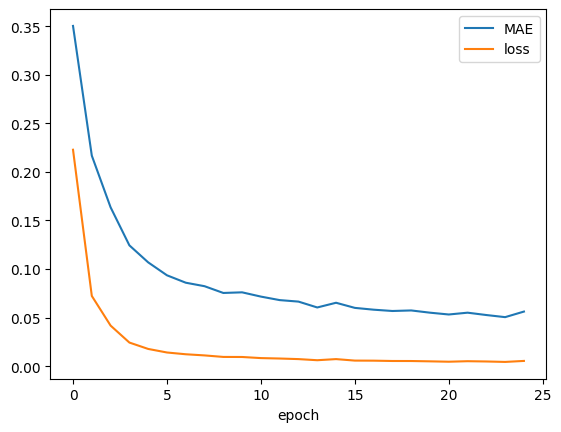

In [24]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [25]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [26]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 5ms/step


In [27]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 0s 5ms/step


In [28]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)

    return mse.result().numpy(), mae.result().numpy()

In [29]:
print(GOOG_y_test.shape, GOOG_predictions.shape)
mse, mae = compute_metrics(GOOG_y_test, GOOG_predictions)
print(mae)

(1260, 1) (1260, 1)
0.098557964


###4.4.5 Predicted vs Actual Price

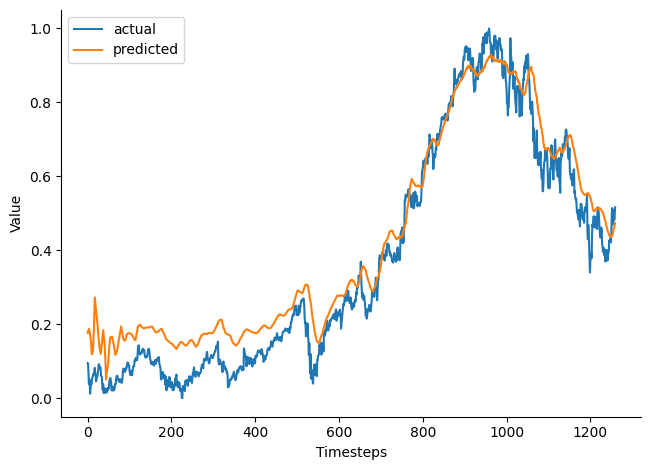

In [98]:

plt.plot(GOOG_y_test, label="actual")
plt.plot(GOOG_predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [30]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


51/53 [===========================>..] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.0177

53/53 [==============================] - 2s 11ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 6/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 7/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 10/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 13/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 21/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 22ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 20ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 36/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 37/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 41/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 44/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 45/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 49/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 58/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 61/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 62/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 63/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 64/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 66/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 76/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 19ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 79/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 80/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 81/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 85/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 87/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 88/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 90/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 93/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 102/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 107/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 113/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 114/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 115/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 116/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 117/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0467 - mean_squared_error: 0.0467

53/53 [==============================] - 1s 12ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 119/200
53/53 [==============================] - ETA: 0s - loss: 0.1185 - mean_squared_error: 0.1185

53/53 [==============================] - 1s 16ms/step - loss: 0.1185 - mean_squared_error: 0.1185
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.2349 - mean_squared_error: 0.2349

53/53 [==============================] - 1s 15ms/step - loss: 0.2355 - mean_squared_error: 0.2355
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2374 - mean_squared_error: 0.2374

53/53 [==============================] - 1s 15ms/step - loss: 0.2371 - mean_squared_error: 0.2371
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.2627 - mean_squared_error: 0.2627

53/53 [==============================] - 1s 16ms/step - loss: 0.2627 - mean_squared_error: 0.2627
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.2645 - mean_squared_error: 0.2645

53/53 [==============================] - 1s 17ms/step - loss: 0.2645 - mean_squared_error: 0.2645
Epoch 124/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2612 - mean_squared_error: 0.2612

53/53 [==============================] - 1s 16ms/step - loss: 0.2632 - mean_squared_error: 0.2632
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.2610 - mean_squared_error: 0.2610

53/53 [==============================] - 1s 12ms/step - loss: 0.2620 - mean_squared_error: 0.2620
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.2651 - mean_squared_error: 0.2651

53/53 [==============================] - 1s 12ms/step - loss: 0.2642 - mean_squared_error: 0.2642
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.2655 - mean_squared_error: 0.2655

53/53 [==============================] - 1s 12ms/step - loss: 0.2655 - mean_squared_error: 0.2655
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.2620 - mean_squared_error: 0.2620

53/53 [==============================] - 1s 12ms/step - loss: 0.2620 - mean_squared_error: 0.2620
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.2618 - mean_squared_error: 0.2618

53/53 [==============================] - 1s 12ms/step - loss: 0.2633 - mean_squared_error: 0.2633
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2639 - mean_squared_error: 0.2639

53/53 [==============================] - 1s 12ms/step - loss: 0.2612 - mean_squared_error: 0.2612
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2619 - mean_squared_error: 0.2619

53/53 [==============================] - 1s 13ms/step - loss: 0.2626 - mean_squared_error: 0.2626
Epoch 132/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2633 - mean_squared_error: 0.2633

53/53 [==============================] - 1s 11ms/step - loss: 0.2641 - mean_squared_error: 0.2641
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2650 - mean_squared_error: 0.2650

53/53 [==============================] - 1s 13ms/step - loss: 0.2622 - mean_squared_error: 0.2622
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.2645 - mean_squared_error: 0.2645

53/53 [==============================] - 1s 13ms/step - loss: 0.2645 - mean_squared_error: 0.2645
Epoch 135/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2602 - mean_squared_error: 0.2602

53/53 [==============================] - 1s 12ms/step - loss: 0.2609 - mean_squared_error: 0.2609
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.2632 - mean_squared_error: 0.2632

53/53 [==============================] - 1s 12ms/step - loss: 0.2632 - mean_squared_error: 0.2632
Epoch 137/200
53/53 [==============================] - ETA: 0s - loss: 0.2636 - mean_squared_error: 0.2636

53/53 [==============================] - 1s 12ms/step - loss: 0.2636 - mean_squared_error: 0.2636
Epoch 138/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2632 - mean_squared_error: 0.2632

53/53 [==============================] - 1s 11ms/step - loss: 0.2639 - mean_squared_error: 0.2639
Epoch 139/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2654 - mean_squared_error: 0.2654

53/53 [==============================] - 1s 12ms/step - loss: 0.2633 - mean_squared_error: 0.2633
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.2642 - mean_squared_error: 0.2642

53/53 [==============================] - 1s 14ms/step - loss: 0.2648 - mean_squared_error: 0.2648
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2649 - mean_squared_error: 0.2649

53/53 [==============================] - 1s 15ms/step - loss: 0.2649 - mean_squared_error: 0.2649
Epoch 142/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2649 - mean_squared_error: 0.2649

53/53 [==============================] - 1s 15ms/step - loss: 0.2646 - mean_squared_error: 0.2646
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634

53/53 [==============================] - 1s 16ms/step - loss: 0.2634 - mean_squared_error: 0.2634
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2657 - mean_squared_error: 0.2657

53/53 [==============================] - 1s 16ms/step - loss: 0.2646 - mean_squared_error: 0.2646
Epoch 145/200
52/53 [============================>.] - ETA: 0s - loss: 0.2637 - mean_squared_error: 0.2637

53/53 [==============================] - 1s 16ms/step - loss: 0.2637 - mean_squared_error: 0.2637
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2675 - mean_squared_error: 0.2675

53/53 [==============================] - 1s 16ms/step - loss: 0.2648 - mean_squared_error: 0.2648
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.2637 - mean_squared_error: 0.2637

53/53 [==============================] - 1s 12ms/step - loss: 0.2633 - mean_squared_error: 0.2633
Epoch 148/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2626 - mean_squared_error: 0.2626

53/53 [==============================] - 1s 11ms/step - loss: 0.2639 - mean_squared_error: 0.2639
Epoch 149/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2653 - mean_squared_error: 0.2653

53/53 [==============================] - 1s 10ms/step - loss: 0.2646 - mean_squared_error: 0.2646
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.2642 - mean_squared_error: 0.2642

53/53 [==============================] - 1s 11ms/step - loss: 0.2647 - mean_squared_error: 0.2647
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2633 - mean_squared_error: 0.2633

53/53 [==============================] - 1s 12ms/step - loss: 0.2643 - mean_squared_error: 0.2643
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.2641 - mean_squared_error: 0.2641

53/53 [==============================] - 1s 11ms/step - loss: 0.2644 - mean_squared_error: 0.2644
Epoch 153/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2713 - mean_squared_error: 0.2713

53/53 [==============================] - 1s 11ms/step - loss: 0.2652 - mean_squared_error: 0.2652
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2620 - mean_squared_error: 0.2620

53/53 [==============================] - 1s 11ms/step - loss: 0.2644 - mean_squared_error: 0.2644
Epoch 155/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2631 - mean_squared_error: 0.2631

53/53 [==============================] - 1s 11ms/step - loss: 0.2636 - mean_squared_error: 0.2636
Epoch 156/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2695 - mean_squared_error: 0.2695

53/53 [==============================] - 1s 10ms/step - loss: 0.2643 - mean_squared_error: 0.2643
Epoch 157/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634

53/53 [==============================] - 1s 11ms/step - loss: 0.2640 - mean_squared_error: 0.2640
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2622 - mean_squared_error: 0.2622

53/53 [==============================] - 1s 11ms/step - loss: 0.2631 - mean_squared_error: 0.2631
Epoch 159/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2631 - mean_squared_error: 0.2631

53/53 [==============================] - 1s 10ms/step - loss: 0.2643 - mean_squared_error: 0.2643
Epoch 160/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2650 - mean_squared_error: 0.2650

53/53 [==============================] - 1s 10ms/step - loss: 0.2647 - mean_squared_error: 0.2647
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2611 - mean_squared_error: 0.2611

53/53 [==============================] - 1s 11ms/step - loss: 0.2633 - mean_squared_error: 0.2633
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2640 - mean_squared_error: 0.2640

53/53 [==============================] - 1s 11ms/step - loss: 0.2641 - mean_squared_error: 0.2641
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2632 - mean_squared_error: 0.2632

53/53 [==============================] - 1s 10ms/step - loss: 0.2623 - mean_squared_error: 0.2623
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2613 - mean_squared_error: 0.2613

53/53 [==============================] - 1s 15ms/step - loss: 0.2636 - mean_squared_error: 0.2636
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634

53/53 [==============================] - 1s 15ms/step - loss: 0.2635 - mean_squared_error: 0.2635
Epoch 166/200
53/53 [==============================] - ETA: 0s - loss: 0.2630 - mean_squared_error: 0.2630

53/53 [==============================] - 1s 16ms/step - loss: 0.2630 - mean_squared_error: 0.2630
Epoch 167/200
53/53 [==============================] - ETA: 0s - loss: 0.2617 - mean_squared_error: 0.2617

53/53 [==============================] - 1s 16ms/step - loss: 0.2617 - mean_squared_error: 0.2617
Epoch 168/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2599 - mean_squared_error: 0.2599

53/53 [==============================] - 1s 18ms/step - loss: 0.2613 - mean_squared_error: 0.2613
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.2605 - mean_squared_error: 0.2605

53/53 [==============================] - 1s 16ms/step - loss: 0.2610 - mean_squared_error: 0.2610
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2588 - mean_squared_error: 0.2588

53/53 [==============================] - 1s 15ms/step - loss: 0.2578 - mean_squared_error: 0.2578
Epoch 171/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2615 - mean_squared_error: 0.2615

53/53 [==============================] - 1s 10ms/step - loss: 0.2599 - mean_squared_error: 0.2599
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2626 - mean_squared_error: 0.2626

53/53 [==============================] - 1s 11ms/step - loss: 0.2632 - mean_squared_error: 0.2632
Epoch 173/200
52/53 [============================>.] - ETA: 0s - loss: 0.2623 - mean_squared_error: 0.2623

53/53 [==============================] - 1s 11ms/step - loss: 0.2627 - mean_squared_error: 0.2627
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.2608 - mean_squared_error: 0.2608

53/53 [==============================] - 1s 11ms/step - loss: 0.2605 - mean_squared_error: 0.2605
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2633 - mean_squared_error: 0.2633

53/53 [==============================] - 1s 10ms/step - loss: 0.2632 - mean_squared_error: 0.2632
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2564 - mean_squared_error: 0.2564

53/53 [==============================] - 1s 11ms/step - loss: 0.2569 - mean_squared_error: 0.2569
Epoch 177/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2662 - mean_squared_error: 0.2662

53/53 [==============================] - 1s 11ms/step - loss: 0.2628 - mean_squared_error: 0.2628
Epoch 178/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2618 - mean_squared_error: 0.2618

53/53 [==============================] - 1s 11ms/step - loss: 0.2616 - mean_squared_error: 0.2616
Epoch 179/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2595 - mean_squared_error: 0.2595

53/53 [==============================] - 1s 10ms/step - loss: 0.2604 - mean_squared_error: 0.2604
Epoch 180/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2590 - mean_squared_error: 0.2590

53/53 [==============================] - 1s 11ms/step - loss: 0.2598 - mean_squared_error: 0.2598
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.2604 - mean_squared_error: 0.2604

53/53 [==============================] - 1s 11ms/step - loss: 0.2604 - mean_squared_error: 0.2604
Epoch 182/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2550 - mean_squared_error: 0.2550

53/53 [==============================] - 1s 10ms/step - loss: 0.2567 - mean_squared_error: 0.2567
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.2593 - mean_squared_error: 0.2593

53/53 [==============================] - 1s 10ms/step - loss: 0.2593 - mean_squared_error: 0.2593
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2602 - mean_squared_error: 0.2602

53/53 [==============================] - 1s 11ms/step - loss: 0.2603 - mean_squared_error: 0.2603
Epoch 185/200
52/53 [============================>.] - ETA: 0s - loss: 0.2617 - mean_squared_error: 0.2617

53/53 [==============================] - 1s 11ms/step - loss: 0.2600 - mean_squared_error: 0.2600
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2587 - mean_squared_error: 0.2587

53/53 [==============================] - 1s 10ms/step - loss: 0.2591 - mean_squared_error: 0.2591
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2599 - mean_squared_error: 0.2599

53/53 [==============================] - 1s 11ms/step - loss: 0.2584 - mean_squared_error: 0.2584
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.2579 - mean_squared_error: 0.2579

53/53 [==============================] - 1s 16ms/step - loss: 0.2573 - mean_squared_error: 0.2573
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.2578 - mean_squared_error: 0.2578

53/53 [==============================] - 1s 14ms/step - loss: 0.2578 - mean_squared_error: 0.2578
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.2603 - mean_squared_error: 0.2603

53/53 [==============================] - 1s 15ms/step - loss: 0.2600 - mean_squared_error: 0.2600
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.2606 - mean_squared_error: 0.2606

53/53 [==============================] - 1s 14ms/step - loss: 0.2606 - mean_squared_error: 0.2606
Epoch 192/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2613 - mean_squared_error: 0.2613

53/53 [==============================] - 1s 15ms/step - loss: 0.2598 - mean_squared_error: 0.2598
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.2555 - mean_squared_error: 0.2555

53/53 [==============================] - 1s 15ms/step - loss: 0.2571 - mean_squared_error: 0.2571
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.2637 - mean_squared_error: 0.2637

53/53 [==============================] - 1s 16ms/step - loss: 0.2624 - mean_squared_error: 0.2624
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2555 - mean_squared_error: 0.2555

53/53 [==============================] - 1s 12ms/step - loss: 0.2579 - mean_squared_error: 0.2579
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2572 - mean_squared_error: 0.2572

53/53 [==============================] - 1s 11ms/step - loss: 0.2584 - mean_squared_error: 0.2584
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2591 - mean_squared_error: 0.2591

53/53 [==============================] - 1s 11ms/step - loss: 0.2598 - mean_squared_error: 0.2598
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.2584 - mean_squared_error: 0.2584

53/53 [==============================] - 1s 11ms/step - loss: 0.2592 - mean_squared_error: 0.2592
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2632 - mean_squared_error: 0.2632

53/53 [==============================] - 1s 11ms/step - loss: 0.2636 - mean_squared_error: 0.2636
Epoch 200/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2596 - mean_squared_error: 0.2596

53/53 [==============================] - 1s 11ms/step - loss: 0.2595 - mean_squared_error: 0.2595
Epoch 1/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.0179

53/53 [==============================] - 3s 16ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 2/200
52/53 [============================>.] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.0112

53/53 [==============================] - 1s 15ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

53/53 [==============================] - 1s 15ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 5/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 11ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 6/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 10ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 7/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 10ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 8/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 9/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 10/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 12/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 13/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 15/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 17/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 18/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 19/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 20/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 22/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 15ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 24/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 27/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 35/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 37/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 41/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 43/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 48/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 54/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 56/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 58/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 60/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 64/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 65/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 68/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 69/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 72/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 74/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 75/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 76/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 83/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 84/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 85/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 86/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 88/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 89/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 94/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 96/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 100/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 112/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 113/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 114/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 117/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 121/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 127/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 129/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 133/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 134/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 135/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 136/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 141/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 145/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 148/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 151/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 152/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 153/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 158/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 162/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 165/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 172/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 175/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 176/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 177/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 178/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 180/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 182/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 183/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 184/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 188/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 192/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 193/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 1/200
52/53 [============================>.] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.0182

53/53 [==============================] - 2s 12ms/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

53/53 [==============================] - 1s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 3/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 4/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 8/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 9/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 10/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 11/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 21/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 24/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 27/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 29/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 32/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 35/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 36/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 40/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 42/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 19ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 44/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 19ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 45/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 47/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 50/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 52/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 53/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 57/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 19ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 66/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 67/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 75/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 78/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 19ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 19ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

53/53 [==============================] - 1s 20ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 86/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 89/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 90/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 96/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 99/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 101/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 17ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 109/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 113/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 120/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 121/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 123/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 124/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

53/53 [==============================] - 1s 17ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 19ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 132/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 135/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 136/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 138/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 139/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 141/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 143/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 145/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 146/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 20ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 20ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 20ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 156/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 158/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 163/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 14ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 168/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 20ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 170/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 18ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 171/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

53/53 [==============================] - 1s 18ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 174/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 20ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 176/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 178/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 181/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 15ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 184/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 186/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 187/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 19ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 190/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 19ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 19ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 19ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 20ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 195/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 20ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 197/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 198/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_squared_error: 0.0149

53/53 [==============================] - 2s 14ms/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 2/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 16ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 18ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 9/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 10/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 11/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 13/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 14/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 15/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 18/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 21/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 22/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 25/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 20ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 21ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 27/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 20ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 28/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 20ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 33/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 36/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 40/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 46/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 19ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 22ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 50/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 22ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 21ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 57/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 61/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 63/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 66/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 19ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 18ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 75/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 84/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 85/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 88/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 90/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 92/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 20ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 20ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 104/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 105/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 106/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 109/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 111/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 120/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 121/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 124/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 125/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 126/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 127/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 134/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 135/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 20ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 20ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 21ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 144/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 22ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 145/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 148/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 154/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 157/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 159/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 20ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 160/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 162/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 19ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 166/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

53/53 [==============================] - 1s 15ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 170/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 15ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 171/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 172/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 13ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 173/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 14ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 180/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 182/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 21ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 184/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 19ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 186/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 19ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 190/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 191/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 194/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 195/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 196/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 197/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 13ms/step - loss: 0.0069 - mean_squared_error: 0.0069


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [31]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_train) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


43/48 [=========================>....] - ETA: 0s - loss: 0.0380 - mean_squared_error: 0.0380

48/48 [==============================] - 2s 9ms/step - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 2/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 3/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 11ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 4/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 5/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 12ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 6/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 15ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 7/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 8/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 14ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 9/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 15ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 10/200
48/48 [==============================] - ETA: 0s - loss: 0.0305 - mean_squared_error: 0.0305

48/48 [==============================] - 1s 15ms/step - loss: 0.0305 - mean_squared_error: 0.0305
Epoch 11/200
48/48 [==============================] - ETA: 0s - loss: 0.0313 - mean_squared_error: 0.0313

48/48 [==============================] - 1s 14ms/step - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 12/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0307 - mean_squared_error: 0.0307

48/48 [==============================] - 1s 12ms/step - loss: 0.0305 - mean_squared_error: 0.0305
Epoch 13/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 14/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 15/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 16/200
47/48 [============================>.] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 0s 10ms/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 17/200
48/48 [==============================] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 0s 9ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 18/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 19/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 20/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 21/200
48/48 [==============================] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 9ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 22/200
47/48 [============================>.] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 23/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 9ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 24/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 25/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 26/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 9ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 27/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 9ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 28/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 29/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 30/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 31/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 32/200
47/48 [============================>.] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 9ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 33/200
48/48 [==============================] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 11ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 34/200
47/48 [============================>.] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 14ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 35/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 36/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 14ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 37/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 38/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 15ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 39/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 40/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 14ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 41/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 42/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 43/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 44/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 45/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 46/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 9ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 47/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 48/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 49/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 50/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 51/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 9ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 52/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 53/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 54/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 55/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 56/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 57/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 58/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 59/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 60/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 61/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 62/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 63/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 64/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 13ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 65/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 66/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 14ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 67/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 68/200
48/48 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 69/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 15ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 70/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 71/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 9ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 72/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 73/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 74/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 75/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 76/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 77/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 78/200
47/48 [============================>.] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 79/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 80/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 9ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 81/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 82/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 83/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 84/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 85/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 86/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 87/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 88/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 89/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 90/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 9ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 91/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 13ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 92/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 13ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 93/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 94/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 95/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 96/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 97/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 15ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 98/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 15ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 99/200
47/48 [============================>.] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 100/200
47/48 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 9ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 101/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 102/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 103/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 104/200
48/48 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 9ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 105/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 106/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 107/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 108/200
47/48 [============================>.] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 109/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 9ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 110/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 111/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 112/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 113/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 9ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 114/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 115/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 11ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 116/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 11ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 117/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 118/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 119/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 13ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 120/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 121/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 15ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 122/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 123/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 124/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 15ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 125/200
48/48 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 126/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 127/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 1s 12ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 128/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 129/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 130/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 131/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 132/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 1s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 133/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 134/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 135/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 136/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 137/200
47/48 [============================>.] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 9ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 138/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 139/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 140/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 11ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 141/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 142/200
47/48 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 143/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 144/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 145/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 146/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 9ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 147/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 148/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 15ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 149/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 13ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 150/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 13ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 151/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 152/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 14ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 153/200
47/48 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 154/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 15ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 155/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 156/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 1s 12ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 157/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 158/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 11ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 159/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 160/200
47/48 [============================>.] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 161/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 162/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 1s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 163/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 164/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0318 - mean_squared_error: 0.0318

48/48 [==============================] - 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 165/200
48/48 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 9ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 166/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 167/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 168/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 169/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 170/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 171/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 172/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 173/200
47/48 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 174/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 175/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 176/200
48/48 [==============================] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 11ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 177/200
48/48 [==============================] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 15ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 178/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 1s 14ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 179/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 15ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 180/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 13ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 181/200
47/48 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 15ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 182/200
48/48 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 14ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 183/200
47/48 [============================>.] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 184/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 185/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 186/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 187/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 188/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 189/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.0320

48/48 [==============================] - 0s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 190/200
47/48 [============================>.] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 11ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 191/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.0324

48/48 [==============================] - 1s 10ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 192/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 193/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 0s 10ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 194/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 11ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 195/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 0s 10ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 196/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0312 - mean_squared_error: 0.0312

48/48 [==============================] - 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 197/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 0s 10ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 198/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.0322

48/48 [==============================] - 1s 11ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 199/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 10ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 200/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330


In [32]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [40]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 5ms/step


In [41]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 5ms/step


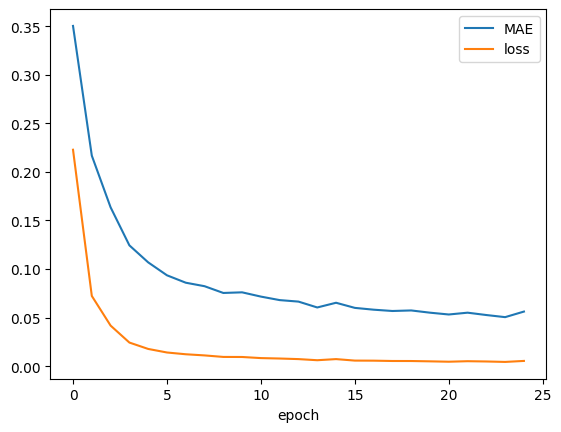

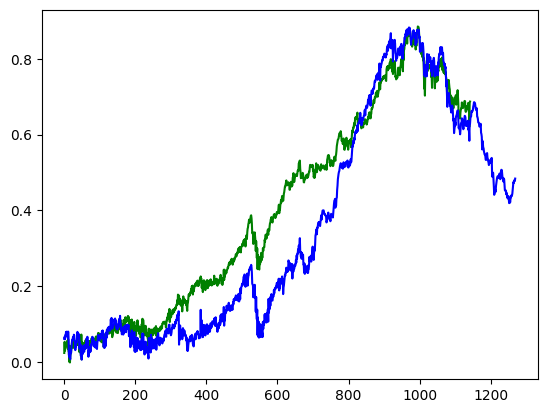

In [34]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()